# Chapter 2

In [1]:
!wget -O scm.py https://raw.githubusercontent.com/CausalAILab/causality-book/main/scm.py

--2024-09-19 15:09:52--  https://raw.githubusercontent.com/CausalAILab/causality-book/main/scm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5789 (5.7K) [text/plain]
Saving to: ‘scm.py’

scm.py              100%[===================>]   5.65K  --.-KB/s    in 0.02s   

2024-09-19 15:09:52 (339 KB/s) - ‘scm.py’ saved [5789/5789]



In [2]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch as T
from sympy import symbols

from IPython.display import Latex

from scm import SymbolicSCM

print(sys.version)

3.11.2 (main, Mar 27 2023, 18:39:42) [Clang 14.0.6 ]



# Definition 2.1.1 -- Structural Causal Model (SCM).

A structural causal model $\mathcal M$ is a 4-tuple $\langle \mathbf U, \mathbf V, \mathcal F, P(\mathbf U)$, where

- $\mathbf U$ is a set of background variables, also called exogenous variables, that are determined by factors outside the model;
- $\mathbf V$ is a set $\{V_1, \dots V_n\}$ of variables, called endogenous, that are determined by other variables in the model — that is, variables in $\mathbf U \cup \mathbf V$.
- $\mathcal F$ is a set of functions $\{f_1, \dots f_n\}$ such that each $f_i$ is a mapping from (the respective domains of) $U_i \cup \mathbf{Pa}_i$ to $V_i$, where $U_i \in \mathbf U, \mathbf{Pa}_i \in \mathbf V \setminus V_i$, and the entire set $\mathcal F$ forms a mapping from $\mathbf U$ to $\mathbf V$. That is, for $i = 1, \dots, n$, each $f_i \in \mathcal F$ is such that

$$v_i \gets f_i(\mathbf{pa}_i, \mathbf{u}_i)$$

i.e., it assigns to a value to $V_i$ that depends on (the values of) a select set of variables in $\mathbf U \cup \mathbf V$; and

- $P(\mathbf U)$ is a probability function defined over the domain of $\mathbf U$.

## Example 2.1
Consider a game of chance described through the SCM $\mathcal M^1 = \langle \mathbf U = \{U_1, U_2\}, \mathbf V = \{X, Y\}, \mathcal F, P(U_1, U_2)\rangle$, where

$$\mathcal F = \begin{cases}
X &\gets U_1 + U_2 \\
Y &\gets U_1 - U_2
\end{cases}$$

and $P(U_i = k) = 1/6$; $i = 1,2$; $k = 1, \dots, 6$.

In [3]:
x, y, u1, u2 = symbols('x y u1 u2')

m1 = SymbolicSCM(
    f={
        x: u1 + u2,
        y: u1 - u2,
    },
    pu={
        # each list characterizes a categorical distribution
        # the first element is the probability of the value 0
        u1: [0, 1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
        u2: [0, 1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
    }
)

In [4]:
m1

SCM([x, y], [u1, u2])

In [5]:
m1.get_probability_table(u=True).head()

,u1,u2,x,y,probability
0,1,1,2,0,0.027778
1,1,2,3,-1,0.027778
2,1,3,4,-2,0.027778
3,1,4,5,-3,0.027778
4,1,5,6,-4,0.027778


In [6]:
m1.get_probability_table().head()

,x,y,probability
0,2,0,0.027778
1,3,-1,0.027778
2,3,1,0.027778
3,4,-2,0.027778
4,4,0,0.027778


First, we plot an empirical histogram of each variable's using $10^6$ samples drawn from its distribution.

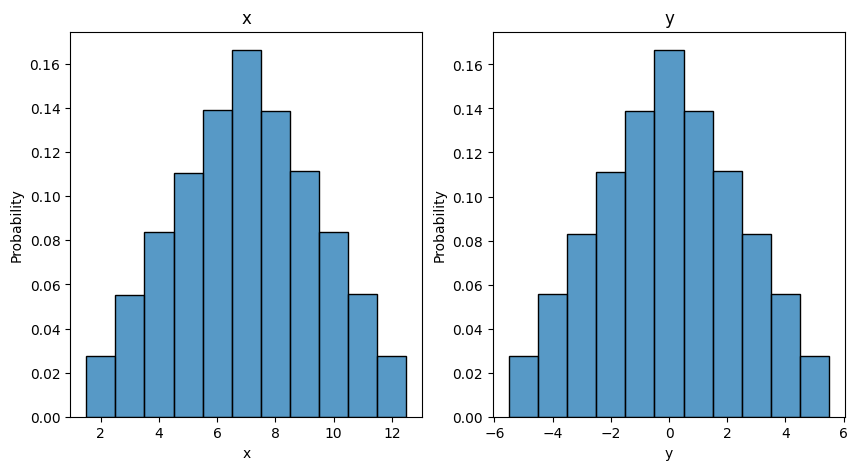

In [7]:
sample = m1.sample(n=10**6)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(sample[x], label='x', ax=axes[0], discrete=True, stat="probability")
axes[0].set_title('x')   
sns.histplot(sample[y], label='y', ax=axes[1], discrete=True, stat="probability")
axes[1].set_title('y')
plt.show()

Then, we compute the joint distribution of $X, Y$. We are able to do so in closed form, given that all variables are discrete.

In [8]:
m1.get_probability_table().head()

,x,y,probability
0,2,0,0.027778
1,3,-1,0.027778
2,3,1,0.027778
3,4,-2,0.027778
4,4,0,0.027778


Text(0.5, 1.0, 'Joint distribution of x and y')

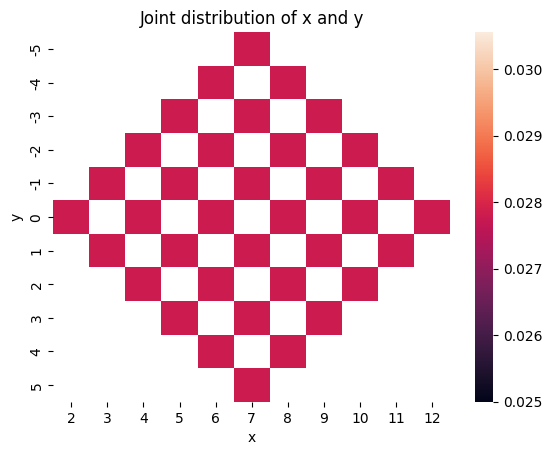

In [9]:
sns.heatmap(pd.pivot(m1.get_probability_table(), index=y, columns=x, values='probability'))
plt.title('Joint distribution of x and y')

# Example 2.2

Consider the following SCM, where the observed variables represent a specific treatment $X$ (e.g., taking a drug), an outcome $Y$ (e.g., survival), and the presence or absence of a symptom $Z$ (e.g., hypertension). The exogenous variables consist of natural resistance to the disease $U_r$ and other unknown sources of variation $U_x, U_y, U_z$.

$$
\mathcal M^2 = \begin{cases}
    \mathbf V &= \{X, Y, Z\}\\
    \mathbf U &= \{U_r, U_x, U_y, U_z\}\\
    \mathcal F &= \begin{cases}
        Z := \mathbf 1[U_r = 1, U_z = 1]\\
        X := \mathbf 1[Z = 1, U_x = 1] + \mathbf 1[Z = 0, U_x = 0]\\
        Y := \mathbf 1[X = 1, U_r = 1] + \mathbf 1[X = 0, U_r = 1, U_y = 1] + \mathbf 1[X = 0, U_r = 0, U_y = 0]\\
    \end{cases}\\
    P(\mathbf U) &= \begin{cases}
       U_r &\sim \mathrm{Bern}(0.25) \\
       U_z &\sim \mathrm{Bern}(0.95) \\
       U_x &\sim \mathrm{Bern}(0.9) \\
       U_y &\sim \mathrm{Bern}(0.7) \\
    \end{cases}
\end{cases}
$$

We may implement this SCM as follows:

In [10]:
z, x, y, ur, uz, ux, uy = symbols('z x y ur uz ux uy')

m2 = SymbolicSCM(
    f={
        z: ur & uz,
        x: z & ux | ~z & ~ux,
        y: x & ur | ~x & ur & uy | ~x & ~ur & ~uy,
    },
    pu={
        ur: 0.25,
        uz: 0.95,
        ux: 0.9,
        uy: 0.7,
    }
)
m2

SCM([z, x, y], [ur, uz, ux, uy])

In [11]:
m2.get_probability_table()

,z,x,y,probability
0,0,0,0,0.475875
1,0,0,1,0.210375
2,0,1,0,0.075000
3,0,1,1,0.001250
4,1,0,0,0.007125
5,1,0,1,0.016625
6,1,1,1,0.213750


## Example 2.3 (2.2 cont.)

We can reproduce Table 2.2 in the textbook by setting `u = True` to also display exogenous variables:

In [12]:
m2.get_probability_table(u=True)

,ur,uz,ux,uy,z,x,y,probability
0,0,0,0,0,0,1,0,0.001125
1,0,0,0,1,0,1,0,0.002625
2,0,0,1,0,0,0,1,0.010125
3,0,0,1,1,0,0,0,0.023625
4,0,1,0,0,0,1,0,0.021375
5,0,1,0,1,0,1,0,0.049875
6,0,1,1,0,0,0,1,0.192375
7,0,1,1,1,0,0,0,0.448875
8,1,0,0,0,0,1,1,0.000375
9,1,0,0,1,0,1,1,0.000875


We may evaluate $P(Y = 1 | X = 1)$ as $P(Y = 1, X = 1) / P(X = 1)$ using Bayes' rule by directly querying the probability table, a pandas DataFrame.

In [13]:
pt = m2.get_probability_table()
pt.query('x == 1 and y == 1').probability.sum() / pt.query('x == 1').probability.sum()

0.7413793103448276

For convenience, we implement the equivalent `SCM.query` to compute queries.

In [14]:
m2.query({y: 1}, given={x: 1})

0.7413793103448276

The `latex` flag causes the function to output the query and value in LaTeX.

In [15]:
m2.query({y: 1}, given={x: 1}, latex=True)

<IPython.core.display.Latex object>

In [16]:
m2.query({y: 1}, given={x: 0}, latex=True)

<IPython.core.display.Latex object>

In [17]:
m2.query({z: 1}, latex=True)

<IPython.core.display.Latex object>

## Example 2.4 (2.1 cont.)

Consider the SCM in Example 2.1.

In [18]:
m1

SCM([x, y], [u1, u2])

In [19]:
m1.query({y: 0}, latex=True)

<IPython.core.display.Latex object>

If we intervene on $Y$, setting $Y = 1$, it is evident $X$ will not change, because it does not depend on $Y$. We can see this when we replace the function for $Y$ with $Y = 1$.

Note that all observed variables in the interventional submodel $\mathcal M_{Y = 1}$ now have a subscript; the unobserved variables are unaffected by the intervention and do not change.

In [20]:
m1.do({y: 1})

SCM([{x}_{y=1}, {y}_{y=1}], [u1, u2])

In [21]:
val = m1.do({x: 2}).query({y: 0})

Latex(f'$P(y = 0 | do(x = 2)) = {val:.4f}$')

<IPython.core.display.Latex object>

## Example 2.5 (2.2 cont.)

Next, we consider **treatment effects**. What is the effect of treatment $X$ on medical outcome $Y$?

Can we just look at the observational quantity $P(Y = 1 | X = 1) - P(Y = 1 | X = 0)$ to make a decision on whether or not to apply the treatment?

In [22]:
m2.do({x: 1}).query({y: 1}, latex=True)

<IPython.core.display.Latex object>

In [23]:
val = m2.query({y: 1}, given={x: 1}) - m2.query({y: 1}, given={x: 0})
Latex(f'$P(y=1 | x=1) - P(y=1 | x=0) \\approx {val:.4g}$')

<IPython.core.display.Latex object>

The total variation of X on Y is positive. So should we enforce the treatment $X = 1$?

Let's compare this difference to the **average treatment effect**, $P(Y = 1 | do(X = 1)) - P(Y = 1 | do(X = 0))$. This represents the difference between control and treatment group in a randomized controlled trial, where treatment assignment is randomized.

In [24]:
val = m2.do({x: 1}).query({y: 1}) - m2.do({x: 0}).query({y: 1})
Latex(f'$P(y=1 | do(x=1)) - P(y=1 | do(x=0)) \\approx {val:.4g}$')

<IPython.core.display.Latex object>

We can see that if we enforce the treatment, $do(X = 1)$, we will actually end up harming the population more than we help it.